# MarNet - Custom CNN Model

### Import Necessary Libraries

In [1]:
import os
import shutil
import glob
import json
from tensorflow.keras.optimizers import Adam
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.applications import VGG16, ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, concatenate, Flatten
import matplotlib.pyplot as plt
from scipy.io import loadmat
from tensorflow.keras.callbacks import EarlyStopping, Callback
import h5py
import cv2
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
from google.colab import drive
from zipfile import ZipFile
from skimage.transform import resize

### Data Loading and Preparation

In [2]:
# !pip install kaggle

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [5]:

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"martinsogiekpolor","key":"a61220f6cf58130235ce8d4caaf0d492"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!rm kaggle.json

In [7]:
!kaggle datasets list

ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
myrios/cost-of-living-index-by-country-by-number-2024           Cost of Living Index by Country                      3KB  2024-07-19 06:25:42           4171         63  1.0              
abdallahwagih/company-employees                                 Company Employees                                   68KB  2024-08-10 12:13:08           1072         26  0.8235294        
waqi786/heart-attack-dataset                                    ❤️ Heart Attack Risk Factors Dataset                 9KB  2024-08-06 10:57:42           1816         32  1.0              
muhammadehsan000/olympic-historical-dataset-1896-2020           O

In [8]:
!kaggle datasets download -d ashkhagan/figshare-brain-tumor-dataset --force

Dataset URL: https://www.kaggle.com/datasets/ashkhagan/figshare-brain-tumor-dataset
License(s): CC-BY-SA-4.0
100% 839M/839M [01:23<00:00, 9.86MB/s]
100% 839M/839M [01:23<00:00, 10.6MB/s]


In [9]:
image_paths = "/content/drive/MyDrive/Colab Notebooks/figshare-brain-tumor-dataset.zip"
extracted_folder_path = "/content/Tumor_Dataset"

with ZipFile(image_paths, 'r') as zip:
    zip.extractall(extracted_folder_path)
    print('Images extracted successfully.')


Images extracted successfully.


After extracting, merge all the data in each sub folder representing each class into one folder named Merged_Tumor_Dataset and delete any file without the expected file structure which is .mat format.  

In [10]:
# Define the paths
extracted_folder_path = "/content/Tumor_Dataset"
merged_folder_path = "/content/Merged_Tumor_Dataset"

# Create the merged folder if it doesn't exist
if not os.path.exists(merged_folder_path):
    os.makedirs(merged_folder_path)

# Loop through all subdirectories and files
for root, dirs, files in os.walk(extracted_folder_path):
    for file in files:
        # Get the file path and move it to the merged folder
        file_path = os.path.join(root, file)
        shutil.move(file_path, merged_folder_path)

print("Files merged successfully!")

Files merged successfully!


In [11]:
file = glob.glob('/content/Merged_Tumor_Dataset/*.mat')

In [12]:
images = list()
masks = list()
class_labels = []
for fil in file:
    if os.path.isfile(fil):  # Check if it's a file
        with h5py.File(fil,'r') as f:
            try:
                lbl = np.array(f['cjdata']['label']).flatten()
                class_labels.extend(lbl)
                img = cv2.resize(np.array(f['cjdata']['image']), (128,128))
                mask = cv2.resize(np.array(f['cjdata']['tumorMask']), (128,128))
                images.append(img)
                masks.append(mask)
            except KeyError:
                os.remove(fil)  # Delete the file
                print(f"Error: File {fil} does not have the expected data structure and has been deleted.")
                continue

images = np.array(images)
masks = np.array(masks)

unique_class_labels = np.unique(class_labels)
print("Number of unique class labels:", len(unique_class_labels))
print("Number of images:", len(images))
print("Number of masks:", len(masks))

Error: File /content/Merged_Tumor_Dataset/cvind.mat does not have the expected data structure and has been deleted.
Number of unique class labels: 3
Number of images: 3064
Number of masks: 3064


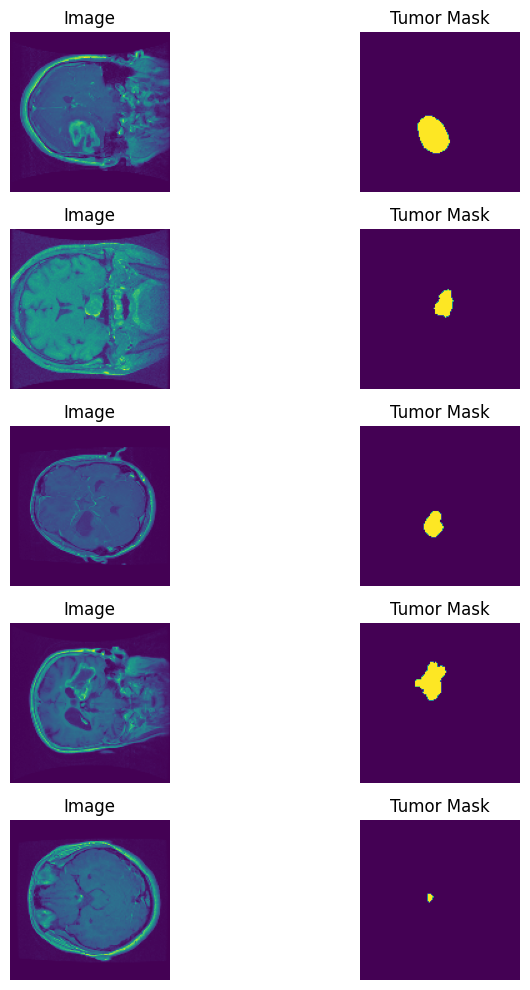

In [13]:
# Visualize five samples
num_samples = 5
fig, axes = plt.subplots(num_samples, 2, figsize=(9, 2*num_samples))

for i in range(num_samples):
    sample_index = np.random.randint(len(images))

    # Plot image
    axes[i, 0].imshow(images[sample_index])
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')

    # Plot tumor mask
    axes[i, 1].imshow(masks[sample_index])
    axes[i, 1].set_title('Tumor Mask')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


#### Data Preparation for Custom CNN Model





In [14]:
print('shape of masks:', masks.shape)
print('shape of images:', images.shape)

shape of masks: (3064, 128, 128)
shape of images: (3064, 128, 128)


In [15]:

train_images, test_images, train_labels, test_labels = train_test_split(images, class_labels, test_size=0.3, random_state=42)

train_labels = np.array(train_labels) - 1
test_labels = np.array(test_labels) - 1

train_labels = to_categorical(train_labels, num_classes=3)
test_labels = to_categorical(test_labels, num_classes=3)

train_images = train_images / 255.0
test_images = test_images / 255.0



### Custom Model

In [16]:
def DenseBlock(inp, name, max_pool=False):
    fp1 = layers.Conv2D(32, (3, 3), activation='relu', padding='SAME', name=name + '_Conv1')(inp)
    fp1 = layers.BatchNormalization(name=name + '_BatchNorm1')(fp1)
    fp1 = layers.Dropout(0.2, name=name + '_Dropout1')(fp1)
    con1 = layers.Concatenate(name=name + '_Concat1')([inp, fp1])

    fp2 = layers.Conv2D(32, (3, 3), activation='relu', padding='SAME', name=name + '_Conv2')(con1)
    fp2 = layers.BatchNormalization(name=name + '_BatchNorm2')(fp2)
    fp2 = layers.Dropout(0.2, name=name + '_Dropout2')(fp2)
    con2 = layers.Concatenate(name=name + '_Concat2')([inp, fp1, fp2])

    fp3 = layers.Conv2D(32, (3, 3), activation='relu', padding='SAME', name=name + '_Conv3')(con2)
    fp3 = layers.BatchNormalization(name=name + '_BatchNorm3')(fp3)
    fp3 = layers.Dropout(0.2, name=name + '_Dropout3')(fp3)
    con3 = layers.Concatenate(name=name + '_Concat3')([inp, fp1, fp2, fp3])

    fp4 = layers.Conv2D(32, (3, 3), activation='relu', padding='SAME', name=name + '_Conv4')(con3)
    fp4 = layers.BatchNormalization(name=name + '_BatchNorm4')(fp4)
    fp4 = layers.Dropout(0.2, name=name + '_Dropout4')(fp4)
    con4 = layers.Concatenate(name=name + '_Concat4')([inp, fp1, fp2, fp3, fp4])

    res = layers.Conv2D(32, (1, 1), activation='relu', padding='SAME', name=name + '_OutDense')(con4)
    res = layers.BatchNormalization(name=name + '_BatchNorm5')(res)

    if max_pool:
        max_p = layers.MaxPool2D(pool_size=(2, 2), name=name + '_Maxpool1')(res)
        return res, max_p
    return res

inp = layers.Input(shape=(128, 128, 1), name='InputLayer')
x = inp
skip = list()

for i in range(4):
    s, x = DenseBlock(x, 'Dense{0}'.format(i + 1), max_pool=True)
    skip.append(s)

x = layers.Conv2D(32, (3, 3), name='BottleNeck_Conv', padding='SAME')(x)
x = layers.BatchNormalization(name='BottleNeck_Normalization')(x)

for i in range(4):
    x = layers.UpSampling2D(size=(2, 2), name='Up-pool{0}'.format(i + 1))(x)
    x = layers.Concatenate(name='Concat{0}'.format(i + 1))([x, skip[-i - 1]])
    x = DenseBlock(x, 'Up_Dense{0}'.format(i + 1))

x = layers.Flatten(name='FlattenLayer')(x)
outp = layers.Dense(3, activation='softmax', name='OutputLayer')(x)
model = Model(inp, outp, name='Marnet')
model.summary()


Model: "Marnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)   │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_Conv1 (Conv2D)     │ (None, 128, 128, 32)   │            320 │ InputLayer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_BatchNorm1         │ (None, 128, 128, 32)   │            128 │ Dense1_Conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_Dropout1 (Dropout) │ (None, 128, 128, 32)   │              0 │ Dense1_BatchNorm1[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_Concat1            │ (None, 128, 128, 33)   │              0 │ InputLayer[0][0],      │
│ (Concatenate)             │                        │                │ Dense1_Dropout1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_Conv2 (Conv2D)     │ (None, 128, 128, 32)   │          9,536 │ Dense1_Concat1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_BatchNorm2         │ (None, 128, 128, 32)   │            128 │ Dense1_Conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_Dropout2 (Dropout) │ (None, 128, 128, 32)   │              0 │ Dense1_BatchNorm2[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_Concat2            │ (None, 128, 128, 65)   │              0 │ InputLayer[0][0],      │
│ (Concatenate)             │                        │                │ Dense1_Dropout1[0][0], │
│                           │                        │                │ Dense1_Dropout2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_Conv3 (Conv2D)     │ (None, 128, 128, 32)   │         18,752 │ Dense1_Concat2[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_BatchNorm3         │ (None, 128, 128, 32)   │            128 │ Dense1_Conv3[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_Dropout3 (Dropout) │ (None, 128, 128, 32)   │              0 │ Dense1_BatchNorm3[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_Concat3            │ (None, 128, 128, 97)   │              0 │ InputLayer[0][0],      │
│ (Concatenate)             │                        │                │ Dense1_Dropout1[0][0], │
│                           │                        │                │ Dense1_Dropout2[0][0], │
│                           │                        │                │ Dense1_Dropout3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_Conv4 (Conv2D)     │ (None, 128, 128, 32)   │         27,968 │ Dense1_Concat3[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1_BatchNorm4         │ (None, 128, 128, 32)   │            128 │ Dense1_Conv4[0][0]     │
│ (BatchNormalization) 

 Total params: 2,481,731 (9.47 MB)

 Trainable params: 2,479,107 (9.46 MB)

 Non-trainable params: 2,624 (10.25 KB)

In [17]:
best_model_path = "/content/drive/MyDrive/Colab Notebooks/best_model.keras"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=best_model_path + "model/logs/", histogram_freq=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(best_model_path + 'model/weights/epoch_{epoch:03d}.keras')
model_best_callback = tf.keras.callbacks.ModelCheckpoint(
    best_model_path,
    monitor='val_loss',
    save_best_only=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

In [18]:
Epochs = 25
Batch_size=32
num_folds = 10

In [19]:
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_accuracy = []
fold_history = []
best_accuracy = 0.0

for fold, (train_index, val_index) in enumerate(kf.split(train_images)):
    print(f"Fold {fold + 1}/{num_folds}")
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=Epochs,
                        batch_size=Batch_size,
                        shuffle=True,
                        callbacks=[tensorboard_callback, model_checkpoint_callback, model_best_callback, early_stopping])

    fold_history.append(history.history)

    # Save the best model
    val_accuracy = history.history['val_accuracy'][-1]
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        model.save(best_model_path)


# Load the best model and test on the test data
model.load_weights(best_model_path)
loss, accuracy = model.evaluate(test_images, test_labels)
# print(f'Test Loss: {loss:.3f}')
print(f'Test Accuracy: {accuracy:.3f}')

Fold 1/10
Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.6248 - loss: 5.4752 - val_accuracy: 0.5953 - val_loss: 35.5078
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 268ms/step - accuracy: 0.8245 - loss: 3.8740 - val_accuracy: 0.7395 - val_loss: 8.1390
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 269ms/step - accuracy: 0.8479 - loss: 3.3694 - val_accuracy: 0.6233 - val_loss: 5.7920
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step - accuracy: 0.9206 - loss: 1.9970 - val_accuracy: 0.6047 - val_loss: 6.8033
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 267ms/step - accuracy: 0.9314 - loss: 1.2702 - val_accuracy: 0.7488 - val_loss: 4.3721
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - accuracy: 0.9372 - loss: 1.3298 - val_accuracy: 0.7070 - val_loss: 5.7140
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - accuracy: 0.9658 - loss: 0.7743 - val_accuracy: 0.7442 - val_loss: 6.9452
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.9743 - loss: 0.4556 -

In [20]:
# Load the best model and test on the test data
model.load_weights(best_model_path)
y_hat = model.predict(test_images)
y_hat = np.argmax(y_hat, axis=-1)
y = np.argmax(test_labels, axis=-1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step


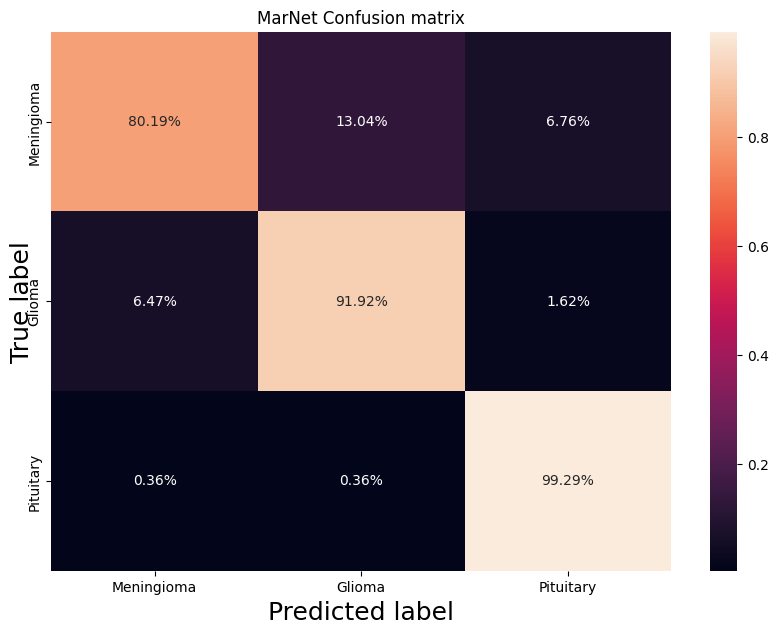

In [21]:
# Print the custom confusion matrix
nCM = confusion_matrix(y.flatten(), y_hat.flatten(), normalize='true')
# nCM = np.pad(nCM, ((0, 1), (0, 1)), mode='constant')
df_cm = pd.DataFrame(nCM, index = ['Meningioma', 'Glioma', 'Pituitary'], columns = ['Meningioma', 'Glioma', 'Pituitary'])
plt.figure(figsize = (10,7))
plt.title('MarNet Confusion matrix')
sn.heatmap(df_cm, annot=True, fmt='.2%')
plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('True label',va='center', fontsize=18)
plt.savefig('ConfusionMat.png')
plt.show()


In [22]:
# Print the classification report
print(classification_report(y.flatten(), y_hat.flatten(), target_names=['Meningioma', 'Glioma', 'Pituitary']))

              precision    recall  f1-score   support

  Meningioma       0.85      0.80      0.83       207
      Glioma       0.93      0.92      0.93       433
   Pituitary       0.93      0.99      0.96       280

    accuracy                           0.92       920
   macro avg       0.91      0.90      0.90       920
weighted avg       0.91      0.92      0.91       920

